In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import xarray as xr
import numpy as np
import seaborn as sns
import datetime as dt

pd.__version__
xr.__version__
np.__version__
sns.__version__

'0.11.2'

In [68]:
import sys
sys.path.append('C:\\Dev\\arpeggioQI\\arpeggioOne\\arpeggioOne')

from macro_lens.jupyter_utils import *
%matplotlib inline

from macro_lens.r_utils import *
%load_ext rpy2.ipython

%load_ext autoreload
%autoreload 2

from macro_lens.stats_utils import *
from macro_lens.pandas_ext import *

pd 1.4.2
xr 2022.3.0
np 1.22.3
sns 0.11.2
rpy2 version:
3.4.5
Python version:
3.9.11 (main, Mar 30 2022, 02:45:55) [MSC v.1916 64 bit (AMD64)]
Looking for R's HOME:
    Environment variable R_HOME: C:\Program Files\R\R-4.1.3\
    InstallPath in the registry: C:\Program Files\R\R-4.1.3
    Environment variable R_USER: None
    Environment variable R_LIBS_USER: None
R version:
    In the PATH: 
    Loading R library from rpy2: OK
Additional directories to load R packages from:
None
C extension compilation:


C:\ProgramData\Anaconda3\envs\q2022\lib\site-packages\rpy2\robjects\packages.py:366: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [2]:
def plot_cum_ret(x):
    return (x+1).cumprod().ffill().plot(logy=True)

from io import StringIO
def pd_read_string(csv_string, sep="\t", **kwargs):
    return pd.read_csv(StringIO(csv_string), sep=sep, **kwargs)


In [3]:
sns.set_style('whitegrid', {"dpi": 300})

In [4]:
import statsmodels.api as sm

# params

In [5]:
data_dir = "C:\\Dev\\DataFree\\"

In [111]:
model_params = dict(
    model="model_mix2",
    remove_rf=False,
    rep_rolling_corr=True,
    rep_incl_alpha=False,
    vol="vol",
)


pd.Series(model_params).to_clipboard()

model_params = pd.read_excel(data_dir + "model_data.xlsx", engine='openpyxl', sheet_name="settings")

model_params = model_params.set_index("key").param.to_dict()
model_params

rolling_prm = dict(date=12*10, min_periods=12*4)

{'model': 'model_sbbi_5',
 'remove_rf': True,
 'rep_rolling_corr': True,
 'rep_incl_alpha': False,
 'vol': 'vol_1y'}

# get data

In [112]:
datas = {}

### gold

In [113]:
file_name = "gold and silver.xlsx"
a = pd.read_excel(data_dir + file_name, sheet_name="data", engine='openpyxl',)
a["date"] = [pd.to_datetime(_, infer_datetime_format=True) for _ in a.date]
a = a.set_index("date")
datas[file_name] = a

### commodities

In [114]:
file_name = "Commodities for the Long Run Index Level Data Monthly.xlsx"
a = pd.read_excel(data_dir + file_name, sheet_name="Commodities for the Long Run", engine='openpyxl', skiprows=10)
a["date"] = pd.to_datetime(a.Date, infer_datetime_format=True)
a = a.set_index("date")
datas[file_name] = a

### rp

In [115]:
file_name = "Century of Factor Premia Monthly.xlsx"
a = pd.read_excel(
    data_dir + file_name, 
    sheet_name="Century of Factor Premia", 
    engine='openpyxl', 
    skiprows=18)
a = a.set_index("Unnamed: 0")
datas[file_name] = a

### shiller

<AxesSubplot:xlabel='date'>

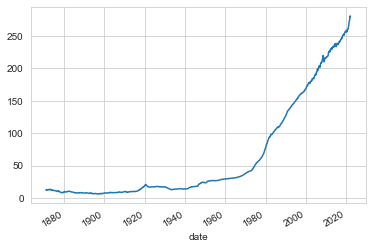

In [116]:
file_name = "ie_data.xls"
a = pd.read_excel(data_dir + file_name, sheet_name="Data", skiprows=7)
a = a.dropna(subset=["Date"])

def convert(a):
    return dt.datetime(
        int(np.floor(a)), 
        int(np.round((a - np.floor(a))*100)), 
        15
    )

a["date"] = a.Date.apply(convert)
a = a.set_index("date")
a["source"] = file_name
a.CPI.plot()
datas[file_name] = a

### sbbi

In [117]:
file_name = "stocks-bonds-bills-and-inflation-data.xlsx"
a = pd.read_excel(data_dir + file_name, sheet_name="--Monthly SBBI Data--", engine='openpyxl', skiprows=10)
a["date"] = a["More Descriptive Name of Series:"]
a = a.dropna(subset=["date"])
a = a.set_index("date")
datas[file_name] = a

### cpi

In [118]:
file_name = "cpi.xlsx"
a = pd.read_excel(data_dir + file_name, sheet_name="data", engine='openpyxl')
a = a.dropna(subset=["date"])
a = a.set_index("date")
datas[file_name] = a

### sectors

In [119]:
file_name = "12_Industry_Portfolios.CSV"
a = pd.read_csv(data_dir + file_name, skiprows=11)
i_to = a[a["Unnamed: 0"].isnull()].index[0]
a = a.iloc[:i_to]
a["date"] = a["Unnamed: 0"].astype(str).str.strip()

a = a[a.date.str.len()==6]
a["date"] = pd.to_datetime("15/" + a.date.str[4:6] + "/" + a.date.str[:4], infer_datetime_format=True)
a = a.set_index("date").astype(float)
datas[file_name] = a

### combine

In [120]:
data = pd.DataFrame()
for k, data_ in datas.items():
    data_.index = data_.index + pd.tseries.offsets.MonthEnd(0)
    assert data_.shape[0] == data_.index.unique().shape[0], f"duplicates {k}"
    data = pd.merge(data, data_, left_index=True, right_index=True, how="outer")

data.to_csv("all.pkl")
data_org = data.copy(True)

In [121]:
is_num = data.dtypes.astype(str).isin(["float64"])
data = data.loc[:, is_num]

### adjustments

In [122]:
defs0 = pd.read_excel(data_dir + "model_data.xlsx", engine='openpyxl', sheet_name="defs")
defs0

,asset_class,ticker,adjustment,key,ex_rf,model_mix,model_mix_5,model_aqr,model_sbbi,model_sbbi_5
0,precious_metals,gold,price,gold,True,precious_metals,precious_metals,NaN,NaN,NaN
1,precious_metals,silver,price,silver,True,precious_metals,precious_metals,precious_metals,precious_metals,precious_metals
2,comm,Excess return of equal-weight commodities port...,ret,aqr_comm_,True,NaN,NaN,NaN,NaN,NaN
3,stocks,Equity indices Market,ret,aqr_stocks,True,stocks,stocks,stocks,NaN,NaN
4,bonds,Fixed income Market,ret,aqr_bonds,True,bonds,bonds,bonds,NaN,NaN
5,comm,Commodities Market,ret,aqr_comm,True,NaN,NaN,comm,comm,NaN
6,stocks,Ibbotson® SBBI® US Large-Cap Stocks (Total Ret...,ret,sbbi_stocks,False,stocks,stocks,NaN,stocks,stocks
7,stocks,Ibbotson® SBBI® US Small-Cap Stocks (Total Ret...,ret,sbbi_small_caps,False,NaN,NaN,NaN,NaN,NaN
8,bonds,Ibbotson® SBBI® US Long-term (20-Year) Corpora...,ret,sbbi_corp,False,NaN,NaN,NaN,NaN,NaN
9,bonds,Ibbotson® SBBI® US Long-term (20-Year) Governm...,ret,sbbi_govt_20,False,bonds,NaN,NaN,bonds,NaN


In [123]:
defs = defs0.copy(True)
defs = defs[defs.ticker.isin(data_org.columns)]
data = data_org.copy(True)[defs.ticker]

# convert tri to ret
is_tri = defs.adjustment.isin(["price", "tri"])
is_tri = defs.ticker[is_tri]
data[is_tri] = data[is_tri].ffill().pct_change().where(data[is_tri].notnull())

# multiply if adjustment is numeric
is_num = [isinstance(_, (float, int)) for _ in defs.adjustment]
is_num = defs.ticker[is_num]
adj = defs.set_index("ticker").loc[is_num].adjustment.astype(float).values[None, :]
data[is_num] = data[is_num] * adj

# remove rf
if model_params["remove_rf"]:
    ex_rf = defs.ex_rf
    remove_rf = defs.ticker[~ex_rf]
    data[remove_rf] = data[remove_rf] - data["Ibbotson® SBBI® US (30-Day) Treasury Bills"].values[:, None]

# rename
data = data.rename(columns=defs.set_index("ticker").key.to_dict())
data = data[slice("1920", None)]


### special cases

In [124]:
corp = sm.OLS(data["sbbi_corp"], data[['sbbi_govt_20']], missing="drop").fit()
corp.summary()
data = data.merge(corp.resid.rename("sbbi_corp_spreads"), left_index=True, right_index=True, how="outer")

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              sbbi_corp   R-squared (uncentered):                   0.682
Model:                            OLS   Adj. R-squared (uncentered):              0.681
Method:                 Least Squares   F-statistic:                              2470.
Date:                Wed, 15 Jun 2022   Prob (F-statistic):                   6.31e-289
Time:                        17:46:24   Log-Likelihood:                          3425.1
No. Observations:                1154   AIC:                                     -6848.
Df Residuals:                    1153   BIC:                                     -6843.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
sbbi_govt_20     0.7413      0.015     49.698      0.000       0.712       0.771
==============================================================================
Omnibus:                      222.209   Durbin-Watson:                   2.058
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4836.187
Skew:                          -0.217   Prob(JB):                         0.00
Kurtosis:                      13.020   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [125]:
comm = sm.OLS(data["aqr_comm"], data[["gold", "silver"]], missing="drop").fit()
comm.summary()
data = data.merge(comm.resid.rename("comm_ex_precious_metals"), left_index=True, right_index=True, how="outer")

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               aqr_comm   R-squared (uncentered):                   0.101
Model:                            OLS   Adj. R-squared (uncentered):              0.100
Method:                 Least Squares   F-statistic:                              63.32
Date:                Wed, 15 Jun 2022   Prob (F-statistic):                    8.73e-27
Time:                        17:46:26   Log-Likelihood:                          1921.7
No. Observations:                1126   AIC:                                     -3839.
Df Residuals:                    1124   BIC:                                     -3829.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
gold           0.1531      0.031      4.927      0.000       0.092       0.214
silver         0.1134      0.020      5.635      0.000       0.074       0.153
==============================================================================
Omnibus:                      158.032   Durbin-Watson:                   1.737
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              687.910
Skew:                           0.589   Prob(JB):                    4.19e-150
Kurtosis:                       6.644   Cond. No.                         2.19
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [126]:
sectors = defs[defs.asset_class=="sectors"].key

models = [
    sm.OLS(data[s], data["sbbi_stocks"], missing="drop").fit()
    for s in sectors
]

pd.concat([m.params for m in models], keys=sectors)
pd.Series([m.rsquared for m in models], index=sectors)

sectors_ex_market = pd.concat([m.resid for m in models], keys=sectors + "_ex_market", axis=1)

data = data.merge(sectors_ex_market, left_index=True, right_index=True, how="outer")

key                      
sector_nodur  sbbi_stocks    0.745735
sector_durbl  sbbi_stocks    1.265144
sector_manuf  sbbi_stocks    1.169842
sector_enrgy  sbbi_stocks    0.890102
sector_chems  sbbi_stocks    0.957148
sector_buseq  sbbi_stocks    1.241411
sector_telcm  sbbi_stocks    0.653140
sector_utils  sbbi_stocks    0.771134
sector_shops  sbbi_stocks    0.948985
sector_hlth   sbbi_stocks    0.827266
sector_money  sbbi_stocks    1.139901
sector_other  sbbi_stocks    1.089967
dtype: float64

key
sector_nodur    0.765118
sector_durbl    0.740243
sector_manuf    0.897740
sector_enrgy    0.570095
sector_chems    0.821446
sector_buseq    0.814028
sector_telcm    0.586562
sector_utils    0.579773
sector_shops    0.776559
sector_hlth     0.645466
sector_money    0.828258
sector_other    0.819968
dtype: float64

<AxesSubplot:>

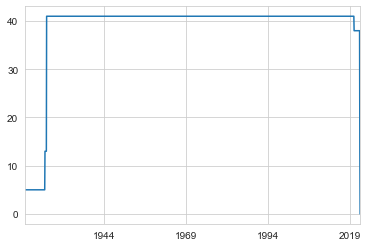

In [127]:
data.notnull().sum(axis=1).plot()

,Avg Return,Period Return,Volatility,Sharpe
aqr_bonds,0.018031,5.310962,0.033619,0.536322
sbbi_corp,0.028968,12.277966,0.075954,0.381389
sbbi_govt_20,0.025008,7.846631,0.084805,0.294890
sbbi_govt_5,0.017778,5.075001,0.041950,0.423795


,aqr_bonds,sbbi_corp,sbbi_govt_20,sbbi_govt_5
aqr_bonds,1.000000,0.624152,0.677359,0.582362
sbbi_corp,0.624152,1.000000,0.824302,0.706619
sbbi_govt_20,0.677359,0.824302,1.000000,0.822165
sbbi_govt_5,0.582362,0.706619,0.822165,1.000000


<AxesSubplot:>

,aqr_bonds,sbbi_corp,sbbi_govt_20,sbbi_govt_5
aqr_bonds,1.000000,0.624152,0.677359,0.582362
sbbi_corp,0.624152,1.000000,0.824302,0.706619
sbbi_govt_20,0.677359,0.824302,1.000000,0.822165
sbbi_govt_5,0.582362,0.706619,0.822165,1.000000


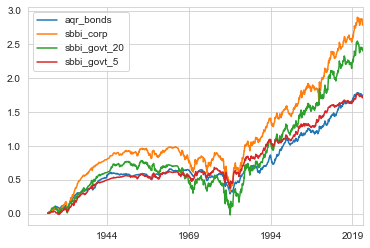

,Avg Return,Period Return,Volatility,Sharpe
aqr_comm_,0.043865,22.010143,0.165569,0.264934
aqr_comm,0.050725,38.056244,0.160096,0.316842
comm_ex_precious_metals,0.026802,4.247119,0.151986,0.176348


,aqr_comm_,aqr_comm,comm_ex_precious_metals
aqr_comm_,1.00000,1.00000,0.94818
aqr_comm,1.00000,1.00000,0.94818
comm_ex_precious_metals,0.94818,0.94818,1.00000


<AxesSubplot:>

,aqr_comm_,aqr_comm,comm_ex_precious_metals
aqr_comm_,1.00000,1.00000,0.94818
aqr_comm,1.00000,1.00000,0.94818
comm_ex_precious_metals,0.94818,0.94818,1.00000


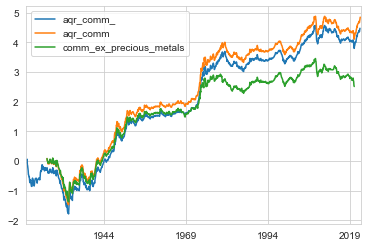

,Avg Return,Period Return,Volatility,Sharpe
sbbi_cpi,0.028933,15.850031,0.018268,1.583804
cpi,0.026741,15.011429,0.019942,1.340966
shiller_cpi,0.026592,14.785317,0.019947,1.333161


,sbbi_cpi,cpi,shiller_cpi
sbbi_cpi,1.000000,1.000000,0.996402
cpi,1.000000,1.000000,0.997157
shiller_cpi,0.996402,0.997157,1.000000


<AxesSubplot:>

,sbbi_cpi,cpi,shiller_cpi
sbbi_cpi,1.000000,1.000000,0.996402
cpi,1.000000,1.000000,0.997157
shiller_cpi,0.996402,0.997157,1.000000


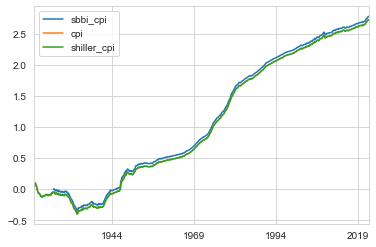

,Avg Return,Period Return,Volatility,Sharpe
gold,0.057082,81.964199,0.169529,0.336711
silver,0.058652,11.287879,0.267485,0.219272


,gold,silver
gold,1.00000,0.54629
silver,0.54629,1.00000


<AxesSubplot:>

,gold,silver
gold,1.00000,0.54629
silver,0.54629,1.00000


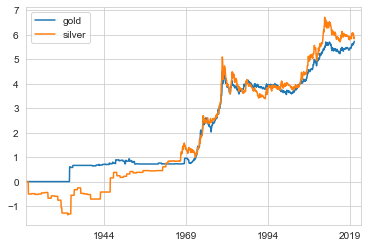

,Avg Return,Period Return,Volatility,Sharpe
sbbi_rf,0.032097,21.735407,0.008709,3.685635


,sbbi_rf
sbbi_rf,1.0


<AxesSubplot:>

,sbbi_rf
sbbi_rf,1.0


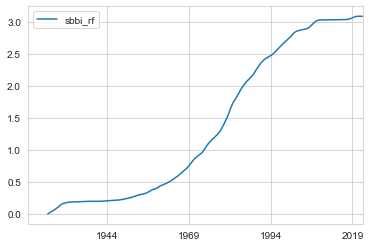

,Avg Return,Period Return,Volatility,Sharpe
sector_nodur,0.083987,897.623036,0.158773,0.528979
sector_durbl,0.109470,1049.969742,0.275215,0.397762
sector_manuf,0.093432,614.589166,0.231034,0.404406
sector_enrgy,0.089822,521.005433,0.220571,0.407225
sector_chems,0.091942,1016.208540,0.197175,0.466294
sector_buseq,0.107466,1221.300445,0.257351,0.417587
sector_telcm,0.069925,234.312962,0.159388,0.438710
sector_utils,0.073701,201.566461,0.189604,0.388711
sector_shops,0.092083,930.715222,0.201129,0.457831
sector_hlth,0.098242,2003.818908,0.191902,0.511939


,sector_nodur,sector_durbl,sector_manuf,sector_enrgy,sector_chems,sector_buseq,sector_telcm,sector_utils,sector_shops,sector_hlth,sector_money,sector_other
sector_nodur,1.000000,0.725430,0.830530,0.612195,0.830724,0.733367,0.686476,0.706018,0.861445,0.792723,0.833351,0.813772
sector_durbl,0.725430,1.000000,0.847403,0.604465,0.796852,0.770093,0.622475,0.592075,0.786086,0.625706,0.783343,0.782156
sector_manuf,0.830530,0.847403,1.000000,0.718899,0.890092,0.861793,0.680224,0.676496,0.837324,0.735941,0.871769,0.917468
sector_enrgy,0.612195,0.604465,0.718899,1.000000,0.664170,0.598451,0.519966,0.584498,0.575273,0.549162,0.675218,0.677077
sector_chems,0.830724,0.796852,0.890092,0.664170,1.000000,0.795487,0.664378,0.678951,0.806147,0.758374,0.815920,0.814441
sector_buseq,0.733367,0.770093,0.861793,0.598451,0.795487,1.000000,0.677494,0.622482,0.794741,0.717902,0.789391,0.814640
sector_telcm,0.686476,0.622475,0.680224,0.519966,0.664378,0.677494,1.000000,0.623914,0.679277,0.607556,0.715471,0.686067
sector_utils,0.706018,0.592075,0.676496,0.584498,0.678951,0.622482,0.623914,1.000000,0.646560,0.615025,0.754641,0.674041
sector_shops,0.861445,0.786086,0.837324,0.575273,0.806147,0.794741,0.679277,0.646560,1.000000,0.745353,0.827653,0.810711
sector_hlth,0.792723,0.625706,0.735941,0.549162,0.758374,0.717902,0.607556,0.615025,0.745353,1.000000,0.749924,0.714216


<AxesSubplot:>

,sector_nodur,sector_durbl,sector_manuf,sector_enrgy,sector_chems,sector_buseq,sector_telcm,sector_utils,sector_shops,sector_hlth,sector_money,sector_other
sector_nodur,1.000000,0.725430,0.830530,0.612195,0.830724,0.733367,0.686476,0.706018,0.861445,0.792723,0.833351,0.813772
sector_durbl,0.725430,1.000000,0.847403,0.604465,0.796852,0.770093,0.622475,0.592075,0.786086,0.625706,0.783343,0.782156
sector_manuf,0.830530,0.847403,1.000000,0.718899,0.890092,0.861793,0.680224,0.676496,0.837324,0.735941,0.871769,0.917468
sector_enrgy,0.612195,0.604465,0.718899,1.000000,0.664170,0.598451,0.519966,0.584498,0.575273,0.549162,0.675218,0.677077
sector_chems,0.830724,0.796852,0.890092,0.664170,1.000000,0.795487,0.664378,0.678951,0.806147,0.758374,0.815920,0.814441
sector_buseq,0.733367,0.770093,0.861793,0.598451,0.795487,1.000000,0.677494,0.622482,0.794741,0.717902,0.789391,0.814640
sector_telcm,0.686476,0.622475,0.680224,0.519966,0.664378,0.677494,1.000000,0.623914,0.679277,0.607556,0.715471,0.686067
sector_utils,0.706018,0.592075,0.676496,0.584498,0.678951,0.622482,0.623914,1.000000,0.646560,0.615025,0.754641,0.674041
sector_shops,0.861445,0.786086,0.837324,0.575273,0.806147,0.794741,0.679277,0.646560,1.000000,0.745353,0.827653,0.810711
sector_hlth,0.792723,0.625706,0.735941,0.549162,0.758374,0.717902,0.607556,0.615025,0.745353,1.000000,0.749924,0.714216


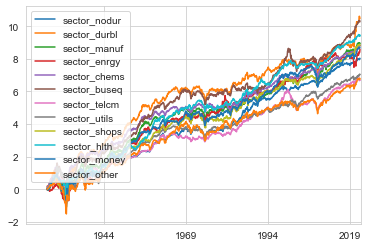

,Avg Return,Period Return,Volatility,Sharpe
sector_nodur_ex_market,0.020555,5.345545,0.077615,0.264840
sector_durbl_ex_market,0.001857,0.473485,0.141188,0.013154
sector_manuf_ex_market,-0.006075,0.429920,0.074362,-0.081692
sector_enrgy_ex_market,0.014110,1.409979,0.145562,0.096937
sector_chems_ex_market,0.010527,1.954003,0.084015,0.125300
sector_buseq_ex_market,0.001872,0.660397,0.111784,0.016750
sector_telcm_ex_market,0.014370,2.372762,0.103221,0.139211
sector_utils_ex_market,0.008109,1.047040,0.123660,0.065572
sector_shops_ex_market,0.011363,1.907254,0.095844,0.118554
sector_hlth _ex_market,0.027875,7.595450,0.115225,0.241919


,sector_nodur_ex_market,sector_durbl_ex_market,sector_manuf_ex_market,sector_enrgy_ex_market,sector_chems_ex_market,sector_buseq_ex_market,sector_telcm_ex_market,sector_utils_ex_market,sector_shops_ex_market,sector_hlth _ex_market,sector_money_ex_market,sector_other_ex_market
sector_nodur_ex_market,1.000000,-0.093345,0.028995,-0.134043,0.199247,-0.246888,0.068706,0.140258,0.405619,0.324036,0.198233,0.116007
sector_durbl_ex_market,-0.093345,1.000000,0.210143,-0.119513,0.092824,-0.013835,-0.095098,-0.175189,0.128571,-0.197164,0.014629,0.023776
sector_manuf_ex_market,0.028995,0.210143,1.000000,0.035537,0.244635,0.064286,-0.197712,-0.196319,0.032239,-0.109701,0.083483,0.442040
sector_enrgy_ex_market,-0.134043,-0.119513,0.035537,1.000000,-0.055260,-0.273150,-0.122899,0.034759,-0.271119,-0.130363,-0.027963,-0.010707
sector_chems_ex_market,0.199247,0.092824,0.244635,-0.055260,1.000000,-0.104785,-0.090475,-0.024596,0.053143,0.136487,-0.035906,-0.024546
sector_buseq_ex_market,-0.246888,-0.013835,0.064286,-0.273150,-0.104785,1.000000,-0.031461,-0.212912,0.013762,-0.009233,-0.161905,-0.003628
sector_telcm_ex_market,0.068706,-0.095098,-0.197712,-0.122899,-0.090475,-0.031461,1.000000,0.109627,0.030397,-0.004563,0.084723,-0.013288
sector_utils_ex_market,0.140258,-0.175189,-0.196319,0.034759,-0.024596,-0.212912,0.109627,1.000000,-0.063965,0.022555,0.241334,-0.043696
sector_shops_ex_market,0.405619,0.128571,0.032239,-0.271119,0.053143,0.013762,0.030397,-0.063965,1.000000,0.147866,0.143698,0.073676
sector_hlth _ex_market,0.324036,-0.197164,-0.109701,-0.130363,0.136487,-0.009233,-0.004563,0.022555,0.147866,1.000000,0.092076,-0.037812


<AxesSubplot:>

,sector_nodur_ex_market,sector_durbl_ex_market,sector_manuf_ex_market,sector_enrgy_ex_market,sector_chems_ex_market,sector_buseq_ex_market,sector_telcm_ex_market,sector_utils_ex_market,sector_shops_ex_market,sector_hlth _ex_market,sector_money_ex_market,sector_other_ex_market
sector_nodur_ex_market,1.000000,-0.093345,0.028995,-0.134043,0.199247,-0.246888,0.068706,0.140258,0.405619,0.324036,0.198233,0.116007
sector_durbl_ex_market,-0.093345,1.000000,0.210143,-0.119513,0.092824,-0.013835,-0.095098,-0.175189,0.128571,-0.197164,0.014629,0.023776
sector_manuf_ex_market,0.028995,0.210143,1.000000,0.035537,0.244635,0.064286,-0.197712,-0.196319,0.032239,-0.109701,0.083483,0.442040
sector_enrgy_ex_market,-0.134043,-0.119513,0.035537,1.000000,-0.055260,-0.273150,-0.122899,0.034759,-0.271119,-0.130363,-0.027963,-0.010707
sector_chems_ex_market,0.199247,0.092824,0.244635,-0.055260,1.000000,-0.104785,-0.090475,-0.024596,0.053143,0.136487,-0.035906,-0.024546
sector_buseq_ex_market,-0.246888,-0.013835,0.064286,-0.273150,-0.104785,1.000000,-0.031461,-0.212912,0.013762,-0.009233,-0.161905,-0.003628
sector_telcm_ex_market,0.068706,-0.095098,-0.197712,-0.122899,-0.090475,-0.031461,1.000000,0.109627,0.030397,-0.004563,0.084723,-0.013288
sector_utils_ex_market,0.140258,-0.175189,-0.196319,0.034759,-0.024596,-0.212912,0.109627,1.000000,-0.063965,0.022555,0.241334,-0.043696
sector_shops_ex_market,0.405619,0.128571,0.032239,-0.271119,0.053143,0.013762,0.030397,-0.063965,1.000000,0.147866,0.143698,0.073676
sector_hlth _ex_market,0.324036,-0.197164,-0.109701,-0.130363,0.136487,-0.009233,-0.004563,0.022555,0.147866,1.000000,0.092076,-0.037812


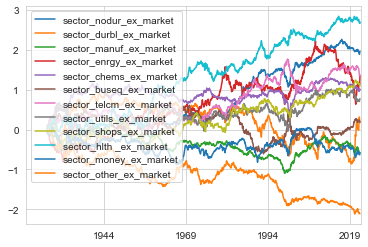

,Avg Return,Period Return,Volatility,Sharpe
aqr_stocks,0.078292,877.007192,0.119398,0.655726
sbbi_stocks,0.083992,598.739634,0.186494,0.450376
sbbi_small_caps,0.119599,2451.981965,0.281343,0.425100
sbbi_corp_spreads,0.010430,2.493316,0.043002,0.242536


,aqr_stocks,sbbi_stocks,sbbi_small_caps,sbbi_corp_spreads
aqr_stocks,1.000000,0.649847,0.571071,0.295458
sbbi_stocks,0.649847,1.000000,0.831777,0.236307
sbbi_small_caps,0.571071,0.831777,1.000000,0.237873
sbbi_corp_spreads,0.295458,0.236307,0.237873,1.000000


<AxesSubplot:>

,aqr_stocks,sbbi_stocks,sbbi_small_caps,sbbi_corp_spreads
aqr_stocks,1.000000,0.649847,0.571071,0.295458
sbbi_stocks,0.649847,1.000000,0.831777,0.236307
sbbi_small_caps,0.571071,0.831777,1.000000,0.237873
sbbi_corp_spreads,0.295458,0.236307,0.237873,1.000000


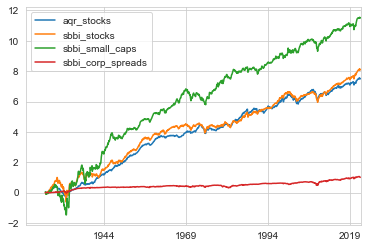

In [128]:
defs = defs0.copy(True)
for g, v in defs.groupby("asset_class"):
    ids = defs[defs.asset_class==g].key.values
    ts = data[ids]
    ts.e.plot_cum_ret()
    display(ts.corr())
    plt.show()

In [129]:
data.to_pickle("all.pkl")

# calc macro factors

In [130]:
data = pd.read_pickle("all.pkl")

### single asset quads

In [131]:
dx = xr.Dataset()
dx["ret"] = data.stack().to_xarray().rename(level_0="date", level_1="asset")

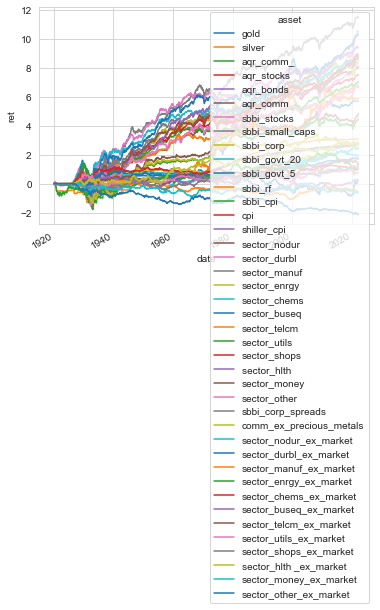

In [132]:
dx.ret.e.plot_cum_ret()

In [133]:
dx["vol"] = dx.ret.std("date") * np.sqrt(12)
dx["vol_70"] = dx.ret.sel(date=slice("1970", None)).std("date") * np.sqrt(12)
dx["vol_70_99"] = dx.ret.sel(date=slice("1970", "1999")).std("date") * np.sqrt(12)
dx["vol_1y"] = dx.ret.rolling(date=12).sum().std("date")
dx["vol_expanding"] = dx.ret.rolling(date=dx.date.size, min_periods=12*30).std().shift(date=1).bfill("date") * np.sqrt(12)
dx[["vol", "vol_70", "vol_1y", "vol_70_99"]].to_array().to_pandas().T

variable,vol,vol_70,vol_1y,vol_70_99
asset,,,,
gold,0.169459,0.215251,0.192504,0.244307
silver,0.267374,0.319994,0.287164,0.337121
aqr_comm_,0.165501,0.147777,0.206982,0.148877
aqr_stocks,0.119346,0.140793,0.150870,0.137602
aqr_bonds,0.033604,0.041591,0.049030,0.039634
aqr_comm,0.160026,0.147900,0.199629,0.148877
sbbi_stocks,0.186414,0.152843,0.197783,0.154132
sbbi_small_caps,0.281221,0.213622,0.298412,0.213824
sbbi_corp,0.075921,0.095754,0.082584,0.093780


In [196]:
model_params["vol"] = "vol_expanding"
#model_params["vol"] = "vol_1y"
model_params

{'model': 'model_sbbi_5',
 'remove_rf': True,
 'rep_rolling_corr': True,
 'rep_incl_alpha': False,
 'vol': 'vol_expanding'}

In [197]:
dx["ret_10"] = dx.ret * 0.1 / dx[model_params["vol"]]

### quads

In [198]:
quad_map_multi = dict(
    stocks=["aqr_stocks", "sbbi_stocks"],
    bonds=["aqr_bonds", "sbbi_govt_20"],
    precious_metals=["gold", "silver"],
    comm=["aqr_comm"],
)

quad_map_single = dict(
    stocks=["aqr_stocks"],
    bonds=["aqr_bonds"],
    precious_metals=["silver"],
    comm=["aqr_comm"],
)

def get_model(defs, model="model_mix"):
    return {k: v.key.values.tolist() for k, v in defs.groupby(model)}

quad_map = get_model(defs, model_params["model"])

quad_map

{'bonds': ['sbbi_govt_5'],
 'comm': ['comm_ex_precious_metals'],
 'precious_metals': ['silver'],
 'stocks': ['sbbi_stocks']}

In [199]:
quads = ["comm", "stocks", "bonds", "precious_metals"]
quads_sorted = ['precious_metals', 'comm', 'bonds', 'stocks']

bonds 1.0
TODO check if 0 or nan
comm 1.0
TODO check if 0 or nan
precious_metals 1.0
TODO check if 0 or nan
stocks 1.0
TODO check if 0 or nan


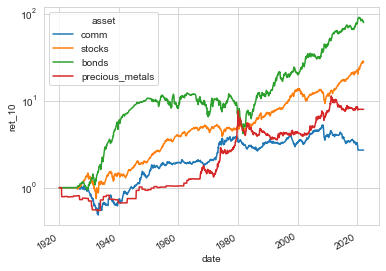

In [200]:
quad_ts = {}
for k, v in quad_map.items():
    ts = dx.ret_10.sel(asset=v)
    denom = ts.to_pandas().corr().sum().sum()**0.5
    print(k, denom)
    print("TODO check if 0 or nan")
    quad_ts[k] = ts.sum("asset")/denom

quad_ts = xr.concat(quad_ts.values(), dim=pd.Index(quad_ts.keys(), name="asset"))

(quad_ts+1).sel(asset=quads).cumprod("date").plot(x="date", hue="asset", yscale="log")
plt.show()

### quad preformance

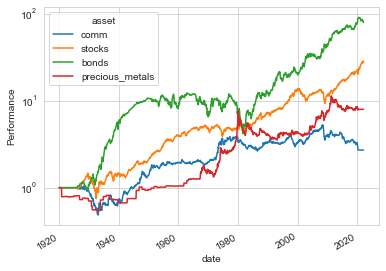

In [201]:
(quad_ts+1).sel(asset=quads).rename("Performance").cumprod("date").plot(x="date", hue="asset", yscale="log")

### gir performance

In [202]:
gir = dict(
    growth=quad_ts.sel(asset=["comm", "stocks"]).mean("asset") - quad_ts.sel(asset=["precious_metals", "bonds"]).mean("asset"),
    inflation=quad_ts.sel(asset=["comm", "precious_metals"]).mean("asset") - quad_ts.sel(asset=["stocks", "bonds"]).mean("asset"),
    risk_appetite=quad_ts.sel(asset=quads).mean("asset"),
)

In [203]:
dx["z_ret"] = xr.concat(gir.values(), pd.Index(gir.keys(), name="macro")).T
dx = dx.sel(macro=list(gir.keys()))

In [204]:
dx.z_ret.to_pandas().e.perf_stats()

,Avg Return,Period Return,Volatility,Sharpe
macro,,,,
growth,-0.014077,0.143479,0.098686,-0.142647
inflation,-0.023492,0.054150,0.099956,-0.235021
risk_appetite,0.031290,21.236469,0.051933,0.602509


Text(0.5, 1.0, 'Macro Factor Portfolios')

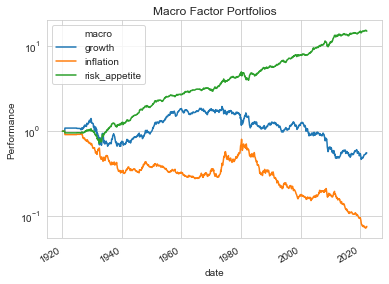

In [191]:
#dx.z_ret.to_pandas().e.plot_cum_ret()
(dx.z_ret+1).rename("Performance").cumprod("date").plot(x="date", hue="macro", yscale="log")
plt.title("Macro Factor Portfolios")



,Avg Return,Period Return,Volatility,Sharpe
macro,,,,
growth,0.016812,3.345389,0.098573,0.170558
inflation,0.033161,17.230398,0.099665,0.332721
risk_appetite,0.024065,9.920243,0.052249,0.460574


Text(0.5, 1.0, 'Macro Factor Trend')

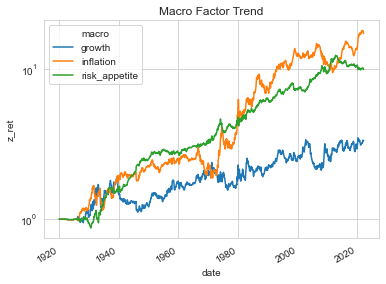

Avg Return         0.073313
Period Return    419.798194
Volatility         0.168277
Sharpe             0.435669
dtype: float64

Text(0.5, 1.0, 'Macro Trend')

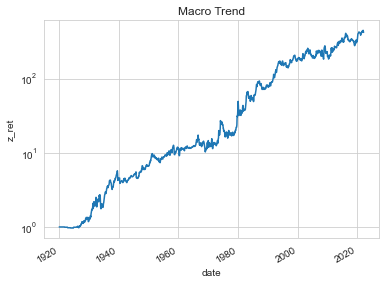

In [212]:
w = (dx.z_ret+1).rolling(date=12).prod()-1
trend = dx.z_ret * w.shift(date=1).pipe(np.sign)


#trend.to_pandas().e.plot_cum_ret()

(trend+1).cumprod("date").plot(x="date", hue="macro", yscale="log")
trend.to_pandas().e.perf_stats()
plt.title("Macro Factor Trend")
plt.show()


(trend.sum("macro")+1).cumprod("date").plot(x="date", hue="macro", yscale="log")
trend.sum("macro").to_pandas().e.perf_stats()
plt.title("Macro Trend")

In [37]:
dx.z_ret.to_pandas().corr()

macro,growth,inflation,risk_appetite
macro,,,
growth,1.000000,0.015653,0.108759
inflation,0.015653,1.000000,-0.071655
risk_appetite,0.108759,-0.071655,1.000000


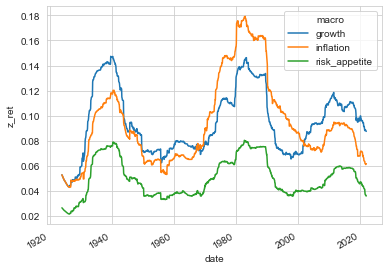

In [143]:
_ = dx.z_ret.rolling(**rolling_prm).std()*np.sqrt(12)
_.plot(x="date", hue="macro")

In [144]:
x = pd.concat([
    dx.ret.to_pandas(),
    dx.z_ret.to_pandas(),
], axis=1)

In [145]:
z = dx.macro.values.tolist()

# replication

In [146]:
assets = dx.asset.values.tolist()
res = [
    sm.OLS(
        x[quad], 
        sm.add_constant(x[z]) if model_params["rep_incl_alpha"] else x[z],
        missing="drop"
    ).fit()
    for quad in assets
]

In [147]:
r2 = pd.Series([_.rsquared for _ in res], index=assets)
r2

gold                       0.283399
silver                     0.848264
aqr_comm_                  0.713284
aqr_stocks                 0.336888
aqr_bonds                  0.277042
aqr_comm                   0.803085
sbbi_stocks                0.725518
sbbi_small_caps            0.532480
sbbi_corp                  0.447288
sbbi_govt_20               0.550333
sbbi_govt_5                0.842246
sbbi_rf                    0.009869
sbbi_cpi                   0.022277
cpi                        0.018981
shiller_cpi                0.018987
sector_nodur               0.595458
sector_durbl               0.519870
sector_manuf               0.673275
sector_enrgy               0.482610
sector_chems               0.597690
sector_buseq               0.575790
sector_telcm               0.470318
sector_utils               0.466614
sector_shops               0.560017
sector_hlth                0.474290
sector_money               0.626790
sector_other               0.591233
sbbi_corp_spreads          0

In [148]:
betas = pd.concat([_.params for _ in res], axis=1, keys=assets)
betas.T

,growth,inflation,risk_appetite
gold,-0.537572,0.555100,0.957832
silver,-1.235004,1.815329,2.495494
aqr_comm_,0.717404,0.712148,2.210513
aqr_stocks,0.517478,-0.154437,1.069645
aqr_bonds,-0.060357,-0.129455,0.115640
aqr_comm,0.719668,0.710143,2.202549
sbbi_stocks,1.120860,-0.560561,2.356627
sbbi_small_caps,1.504991,-0.569421,3.092645
sbbi_corp,-0.119815,-0.351061,0.470143
sbbi_govt_20,-0.247370,-0.432564,0.414372


In [149]:
dx["betas"] = betas.stack().to_xarray().rename(level_0="macro", level_1="asset")
if "const" in betas.T:
    dx["betas_const"] = betas.T.const.to_xarray().rename(index="asset")
    dx["ret_from_z"] = (dx.z_ret * dx.betas).sum("macro") + dx.betas_const
else:
    dx["ret_from_z"] = (dx.z_ret * dx.betas).sum("macro") 

In [150]:
sel_asset = ["gold", "silver", "aqr_comm", "comm_ex_precious_metals", "sbbi_govt_20", "aqr_bonds", "sbbi_stocks", "aqr_stocks"]

In [151]:
def xr_corr(x, dim, rolling_prm=None, fun="corr", dim_appendage="2"):
    x = x.to_series().unstack(dim)

    if not rolling_prm is None:
        rolling_prm = rolling_prm.copy()
        rolling_dim = list(rolling_prm.keys())[0]
        rolling_prm["window"] = rolling_prm[rolling_dim]
        del rolling_prm[rolling_dim]
        
        x = x.rolling(**rolling_prm)
    
    if fun == "corr":
        res = x.corr()
    else:
        res = x.cov()

    if res.columns.nlevels == 1:
        res.columns.name = res.columns.name + dim_appendage
    else:
        res.columns.names = [n + dim_appendage  for n in res.columns.names]
    
    res = res.stack(res.columns.names).to_xarray()
    
    return res

def xr_cov(x, dim, rolling_prm=None, dim_appendage="2"):
    return xr_cov(x, dim, rolling_prm=rolling_prm, fun="cov", dim_appendage=dim_appendage)

In [152]:
def calc_replicated_cov(dx, rolling_prm=dict(date=12*10, min_periods=12*5), rolling_vol=True, rolling_corr=False):
    z_ret = dx.z_ret
    b = dx.betas

    ret = z_ret @ b
    
    if rolling_vol:
        z_vol = z_ret.rolling(**rolling_prm).std()
    else:
        raise Exception("not implemented")
        
    if rolling_corr:
        z_corr = xr_corr(z_ret, "macro", rolling_prm=rolling_prm)
    else:
        z_corr = xr_corr(z_ret, "macro")
        
        
    z_cov = z_vol * z_corr * z_vol.rename(macro="macro2")

    cov = z_cov.fillna(0.) @ b @ b.rename(macro="macro2", asset="asset2")

    vol = xr.DataArray(
        np.diagonal(cov.values, axis1=1, axis2=2)**0.5, 
        coords=[cov.date.values, cov.asset.values],
        dims=["date", "asset"],
    )

    corr = cov / vol / vol.rename(asset="asset2")
    
    rep = xr.Dataset()
    rep["ret"] = ret
    rep["vol"] = vol * np.sqrt(12)
    rep["corr"] = corr
    
    org = xr.Dataset()
    ret = dx.ret
    org["ret"] = ret
    org["vol"] = ret.rolling(**rolling_prm).std() * np.sqrt(12)
    org["corr"] = xr_corr(ret, "asset", rolling_prm)
    
    rep = xr.concat([org, rep], dim=pd.Index(["original", "replicated"], name="version"))
    
    corr_vs = rep.corr.stack(vs=["asset", "asset2"])
    corr_vs = corr_vs.sel(vs=corr_vs.asset>corr_vs.asset2)
    corr_vs = corr_vs.assign_coords(vs=[
        f"{v1} - {v2}" 
        for v1, v2 in corr_vs.vs.values.tolist()
    ])
    
    rep["corr_vs"] = corr_vs
    
    rep["z_vol"] = z_vol * np.sqrt(12)
    rep["z_corr"] = z_corr

    z_corr_vs = z_corr.stack(macro_vs=["macro", "macro2"])
    z_corr_vs = z_corr_vs.sel(macro_vs=z_corr_vs.macro>z_corr_vs.macro2)
    z_corr_vs = z_corr_vs.assign_coords(macro_vs=[
        f"{v1} - {v2}" 
        for v1, v2 in z_corr_vs.macro_vs.values.tolist()
    ])
    
    rep["z_corr_vs"] = z_corr_vs
    
    return rep

rep = calc_replicated_cov(
    dx.sel(asset=sel_asset), 
    rolling_prm, 
    rolling_corr=model_params["rep_rolling_corr"]
).sel(date=slice("1930", None))

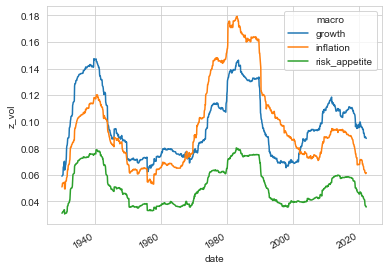

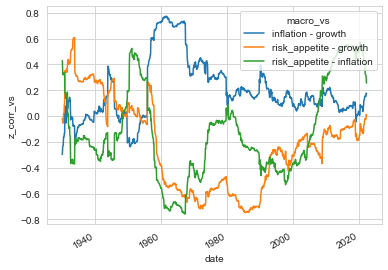

In [153]:
rep.z_vol.plot(x="date", hue="macro")
plt.show()
rep.z_corr_vs.plot(x="date", hue="macro_vs")

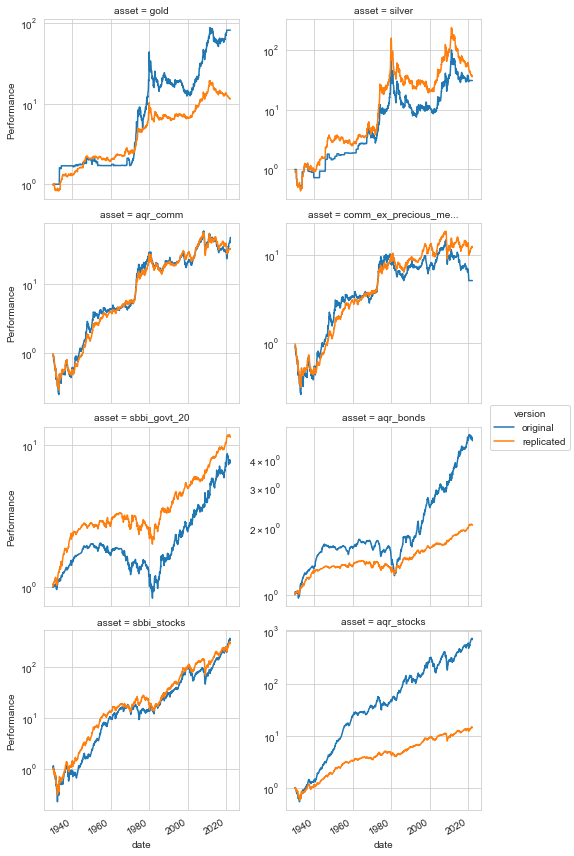

In [154]:
a = (rep.ret+1).cumprod("date").sel(asset=sel_asset).rename("Performance")
a.plot(x="date", hue="version", col="asset", col_wrap=2, sharey=False, yscale="log")

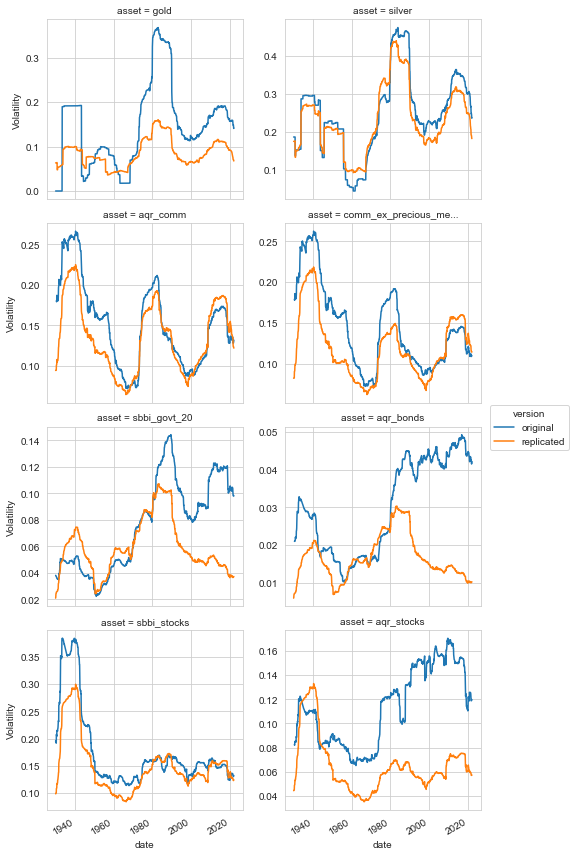

In [155]:
rep.vol.sel(asset=sel_asset).rename("Volatility").plot(x="date", hue="version", col="asset", col_wrap=2, sharey=False)

### corr

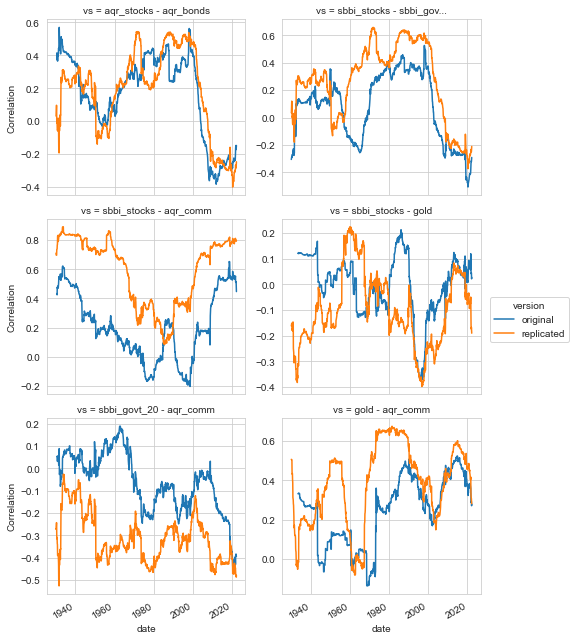

In [156]:
vss = [
    "aqr_stocks - aqr_bonds", 
    "sbbi_stocks - sbbi_govt_20", 
    "sbbi_stocks - aqr_comm", 
    "sbbi_stocks - gold", 
    "sbbi_govt_20 - aqr_comm",
    "gold - aqr_comm",
]
rep.corr_vs.sel(vs=vss).rename("Correlation").plot(x="date", hue="version", col="vs", col_wrap=2, sharey=False)

## export

In [52]:
def xr_to_excel(x, file, rows):
    writer = pd.ExcelWriter(file, engine='xlsxwriter')

    if isinstance(x, list):
        xs = x
    else:
        xs = [x]
    
    for x in xs:
        for x_ in x:
            print(x_)
            if x_ in x.dims:
                continue
            if len(x[x_].dims) <= 2:
                df = x[x_].to_pandas()
            else:
                cols = set(x[x_].dims) - set(rows)
                cols = list(cols)
                df = x[x_].to_series().unstack(cols)
            df.to_excel(writer, sheet_name=x_)

    writer.save()

xr_to_excel([
        dx[["ret", "ret_10", "z_ret", "betas"]].sel(asset=sel_asset),
        rep[["ret", "vol", "corr_vs"]].rename(ret="rep_ret"), 
    ],
    "text.xlsx", 
    rows=["date"]
)

ret
ret_10
z_ret
betas
rep_ret
vol
corr_vs


In [53]:
dx.ret.to_pandas().to_clipboard()

In [54]:
dx.ret_10.to_pandas().to_clipboard()

In [55]:
dx.z_ret.to_pandas().to_clipboard()

In [56]:
dx.betas.to_pandas().T.to_clipboard()

In [57]:
rep.ret.to_series().unstack(["asset", "version"]).to_clipboard()

In [58]:
rep.vol.to_series().unstack(["asset", "version"]).to_clipboard()

In [59]:
rep.corr_vs.to_series().unstack(["vs", "version"]).to_clipboard()

# inflation and growth regimes

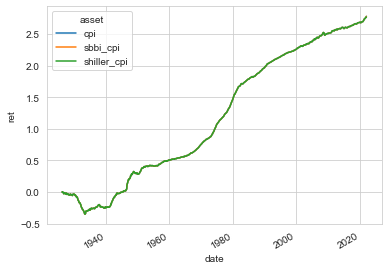

In [157]:
dx.ret.sel(asset=["cpi", "sbbi_cpi", "shiller_cpi"], date=slice("1926", None)).cumsum("date").plot(x="date", hue="asset")
plt.show()

In [163]:
dx.ret.asset

<xarray.DataArray 'asset' (asset: 41)>
array(['gold', 'silver', 'aqr_comm_', 'aqr_stocks', 'aqr_bonds', 'aqr_comm',
       'sbbi_stocks', 'sbbi_small_caps', 'sbbi_corp', 'sbbi_govt_20',
       'sbbi_govt_5', 'sbbi_rf', 'sbbi_cpi', 'cpi', 'shiller_cpi',
       'sector_nodur', 'sector_durbl', 'sector_manuf', 'sector_enrgy',
       'sector_chems', 'sector_buseq', 'sector_telcm', 'sector_utils',
       'sector_shops', 'sector_hlth ', 'sector_money', 'sector_other',
       'sbbi_corp_spreads', 'comm_ex_precious_metals',
       'sector_nodur_ex_market', 'sector_durbl_ex_market',
       'sector_manuf_ex_market', 'sector_enrgy_ex_market',
       'sector_chems_ex_market', 'sector_buseq_ex_market',
       'sector_telcm_ex_market', 'sector_utils_ex_market',
       'sector_shops_ex_market', 'sector_hlth _ex_market',
       'sector_money_ex_market', 'sector_other_ex_market'], dtype=object)
Coordinates:
  * asset    (asset) object 'gold' 'silver' ... 'sector_other_ex_market'

In [160]:
cpi = xr.Dataset()
cpi["cpi"] = (dx.ret.sel(asset="cpi")+1).cumprod("date").ffill("date")
cpi["cpi"] = (dx.ret.sel(asset="gdp")+1).cumprod("date").ffill("date")

cpi["chg_12"] = cpi.cpi / cpi.cpi.shift(date=12) - 1
cpi["surprise"] = cpi.chg_12 - cpi.chg_12.rolling(date=12).mean()
cpi["z_surprise"] = cpi.surprise / cpi.surprise.std("date")
cpi["regime"] = cpi.z_surprise > 0

KeyError: 'gdp'

C:\ProgramData\Anaconda3\envs\q2022\lib\site-packages\pandas\plotting\_matplotlib\core.py:1437: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)
C:\Users\Andreas\AppData\Local\Temp\ipykernel_13932\2441842941.py:12: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  xti = pd.date_range(pd.datetime(1920, 1, 31), pd.datetime(2021, 1, 31), freq="10A-JAN").tolist()


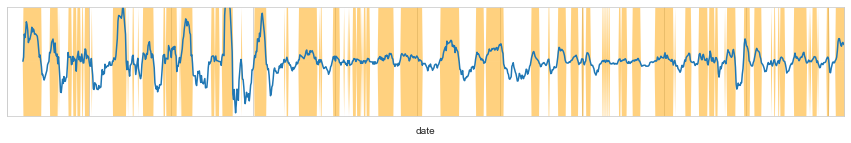

In [159]:
def cpi_regime_plot(cpi):
    if ~isinstance(cpi, pd.DataFrame):
        cpi = cpi.to_array().T.to_pandas()
        
    cpi.z_surprise.plot(figsize=(15, 2))
    (cpi["regime"].astype(float)*4).plot.area(alpha=0.5, linewidth=0, color="orange")
    (-cpi["regime"].astype(float)*4).plot.area(alpha=0.5, linewidth=0, color="orange")
    ax = plt.gca()
    ax.set_ylim([-4, 4])
    ax.set_yticks([])
    ax.set_xlim(["1920", "2022"])
    xti = pd.date_range(pd.datetime(1920, 1, 31), pd.datetime(2021, 1, 31), freq="10A-JAN").tolist()
    ax.set_xticks(xti)

cpi_regime_plot(cpi)

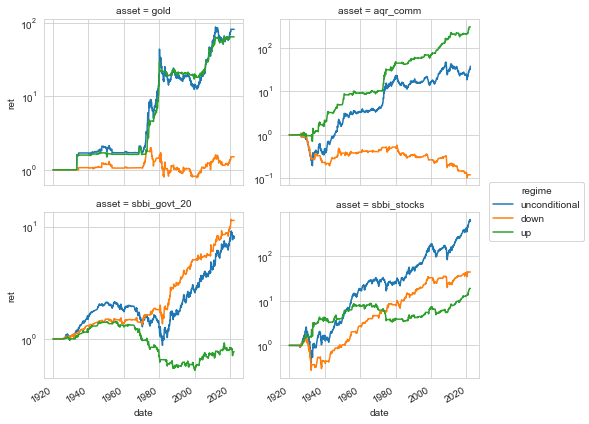

In [63]:
def cpi_regime_split(cpi, ts, plot=False):
    regime = cpi.regime.astype(float).rolling(date=6).mean().shift(date=-6)
    
    ts_in_regime = xr.concat([
        ts, 
        ts*(1-regime), 
        ts*regime
    ], 
        dim=pd.Index(["unconditional", "down", "up"], name="regime")
    )
    
    if plot:
        a = (ts_in_regime+1).cumprod("date").ffill("date")
        a.plot(x="date", hue="regime", col="asset", col_wrap=2, sharey=False, yscale="log")
    
    return ts_in_regime
    
sel_assets = ["gold", "aqr_comm", "sbbi_govt_20", "sbbi_stocks"]
cpi_regime_split(cpi, dx.ret.sel(asset=sel_assets), plot=True);

In [64]:
ts_in_regime = cpi_regime_split(cpi, dx.ret)

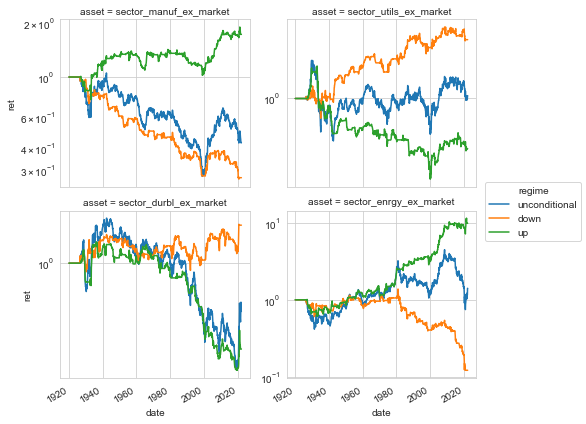

In [65]:
sel_assets = ["sector_manuf_ex_market", "sector_utils_ex_market", "sector_durbl_ex_market", "sector_enrgy_ex_market"]
cpi_regime_split(cpi, dx.ret.sel(asset=sel_assets), plot=True);

In [66]:
ts_in_regime.transpose("date", "asset", "regime").to_series().unstack(["asset", "regime"]).to_clipboard()

In [67]:
cpi.to_array().to_pandas().T.to_clipboard()